# Setup

In [57]:
import pandas as pd
import numpy as np
import json
import os

from IPython.display import display, HTML
from datetime import datetime
import time

import seaborn as sns
import matplotlib.pyplot as plt

import statistics as st
from math import cos, pi

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

# Read data

In [118]:
df = pd.read_csv('train.csv')
test_data = pd.read_csv('test_public.csv')

if os.path.exists('dftrain.csv'):
    dftrain = pd.read_csv('dftrain.csv')
if os.path.exists('dftest.csv'):
    dftest = pd.read_csv('dftest.csv')

# Extract data
- In case dftrain.csv and dftest.csv do not exist, run the following

In [119]:
del df['DAY_TYPE']

In [120]:
times = df.POLYLINE.apply(lambda x: max((x.count('[')-1-1)*15, 0)) # if (x.count('[')-1-1)*15 > 0 else np.nan)
df = df.assign(TRAVEL_TIME = times)

In [123]:
df = df[df.MISSING_DATA != True]

In [122]:
def extract_time(data):
    datetime_timestamp = data.TIMESTAMP.apply(lambda x: datetime.fromtimestamp(x))
    years = datetime_timestamp.apply(lambda x: x.year)
    months = datetime_timestamp.apply(lambda x: x.month)
    weeks = datetime_timestamp.apply(lambda x: x.week) # week of year
    days = datetime_timestamp.apply(lambda x: x.day) # day of month
    hours = datetime_timestamp.apply(lambda x: x.hour) # hour of day
    mins = datetime_timestamp.apply(lambda x: x.minute) # minute of hour
    weekdays = datetime_timestamp.apply(lambda x: x.weekday()) # Monday=0
    
    df_out = data[["TRIP_ID", "TAXI_ID"]]

    df_out = df_out.assign(
        YEAR = years,
        MONTH = months,
        WEEK = weeks,
        DAY = days,
        HOUR = hours,
        MIN = mins,
        WEEKDAY = weekdays
    )
    
    return df_out

In [124]:
%%time
dftrain = extract_time(df)

CPU times: user 21.6 s, sys: 1.99 s, total: 23.6 s
Wall time: 23.6 s


In [125]:
%%time
dftest = extract_time(test_data)

CPU times: user 19.3 ms, sys: 1.27 ms, total: 20.6 ms
Wall time: 18.4 ms


In [126]:
def encode_call_type(in_df, data):
    typeA = data.CALL_TYPE.apply(lambda x: 1 if x == "A" else 0)
    typeB = data.CALL_TYPE.apply(lambda x: 1 if x == "B" else 0)
    typeC = data.CALL_TYPE.apply(lambda x: 1 if x == "C" else 0)
    in_df = in_df.assign(CALL_TYPE_A=typeA, CALL_TYPE_B=typeB, CALL_TYPE_C=typeC)
    return in_df

In [127]:
%%time
dftrain=encode_call_type(dftrain, df)
dftest=encode_call_type(dftest, test_data)

CPU times: user 1.21 s, sys: 205 ms, total: 1.42 s
Wall time: 1.42 s


In [128]:
def get_boolean(in_df, data):
    origin_call = data.ORIGIN_CALL.apply(lambda x: 1 if x is not None else 0)
    origin_stand = data.ORIGIN_STAND.apply(lambda x: 1 if x is not None else 0)
    missing_data = data.MISSING_DATA.apply(lambda x: 1 if x else 0)
    in_df = in_df.assign(ORIGIN_CALL=origin_call, 
                         ORIGIN_STAND=origin_stand, 
                         MISSING_DATA=missing_data)
    return in_df

In [129]:
%%time
dftrain = get_boolean(dftrain, df)
dftest = get_boolean(dftest, test_data)

CPU times: user 1.29 s, sys: 364 ms, total: 1.65 s
Wall time: 1.65 s


In [131]:
dftrain = dftrain.assign(TRAVEL_TIME=df.TRAVEL_TIME, TIMESTAMP=df.TIMESTAMP)

### clean empty rows ###
dftrain.dropna(inplace=True)

dftest=dftest.assign(TIMESTAMP=test_data.TIMESTAMP)
dftest.head(3)

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TIMESTAMP
0,T1,20000542,2014,8,33,14,17,57,3,0,1,0,1,1,0,1408039037
1,T2,20000108,2014,8,33,14,17,50,3,0,1,0,1,1,0,1408038611
2,T3,20000370,2014,8,33,14,17,49,3,0,1,0,1,1,0,1408038568


In [132]:
save_file = False 
if save_file:
    dftrain.to_csv('dftrain.csv', index=False)
    dftest.to_csv('dftest.csv', index=False)

# Helper functions

In [121]:
def plot_2d(top, trip_id):
    plt.figure(figsize=(10, 6))
    x = []
    y = []
    
    for elem in top:
        x.append(elem[0])
        y.append(elem[1])
    print('Number of points', len(x))
    print('First coordinates', x[0], y[0])
    print('Last coordinates', x[-1], y[-1])
    
    # Plot the points
    plt.scatter(x, y)

    # Connect the points with lines
    plt.plot(x, y, 'b-')
    
    # First dot is red; last dot is yellow
    plt.plot(x[0], y[0], '-o', color='red')
    plt.plot(x[-1], y[-1], '-o', color='yellow')
    
    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'TRIP_ID={trip_id} Visualized in 2D')

    # Display the plot
    plt.show()
    
"""[LON, LAT]"""
def get_lon_1st(x):
    if x == '[]':
        lon_1st = 0
    else:
        lon_1st = float(x[2:].split(',')[0])
    return lon_1st

def get_lat_1st(x):
    if x == '[]':
        last_1st = 0
    else:
        tmp = x[2:].split(',')[1]
        if tmp[-1] == ',':
            last_1st = float(tmp[:-1])
        else:
            last_1st = float(tmp[:-2])
    return last_1st

def get_lon_last(x):
    if x == '[]':
        lon_last = 0
    else:
        lon_last = float(x[2:].split('[')[-1].split(',')[0])
    return lon_last

def get_lat_last(x):
    if x == '[]':
        lat_last = 0
    else:
        lat_last = float(x[:-2].split(',')[-1])
    return lat_last

### 2A - Provided training data size

In [4]:
print(df.shape)

(1710670, 9)


In [5]:
df.head(3)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."


In [6]:
df.dtypes

TRIP_ID           int64
CALL_TYPE        object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID           int64
TIMESTAMP         int64
DAY_TYPE         object
MISSING_DATA       bool
POLYLINE         object
dtype: object

### 2A - Provided testing data size

In [7]:
print(test_data.shape)

(320, 8)


In [8]:
test_data.head(3)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False


### 2A - First trip

In [9]:
dftrain.head(1)

,TRIP_ID,TAXI_ID,YEAR,MONTH,WEEK,DAY,HOUR,MIN,WEEKDAY,CALL_TYPE_A,CALL_TYPE_B,CALL_TYPE_C,ORIGIN_CALL,ORIGIN_STAND,MISSING_DATA,TRAVEL_TIME,TIMESTAMP
0,1372636858620000589,20000589,2013,7,27,1,0,0,0,0,0,1,1,1,0,330,1372636858


Number of points 23
First coordinates -8.618643 41.141412
Last coordinates -8.630838 41.154489


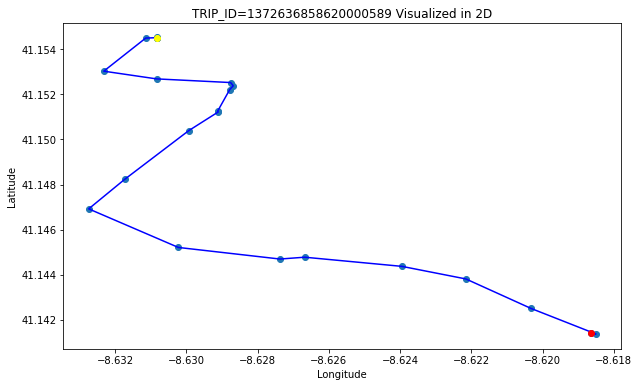

In [10]:
trip_id = 1372636858620000589
plot_2d(eval(df[df.TRIP_ID == trip_id].POLYLINE[0]), trip_id=trip_id)

### 2B - Feature engineering rationales

<AxesSubplot:>

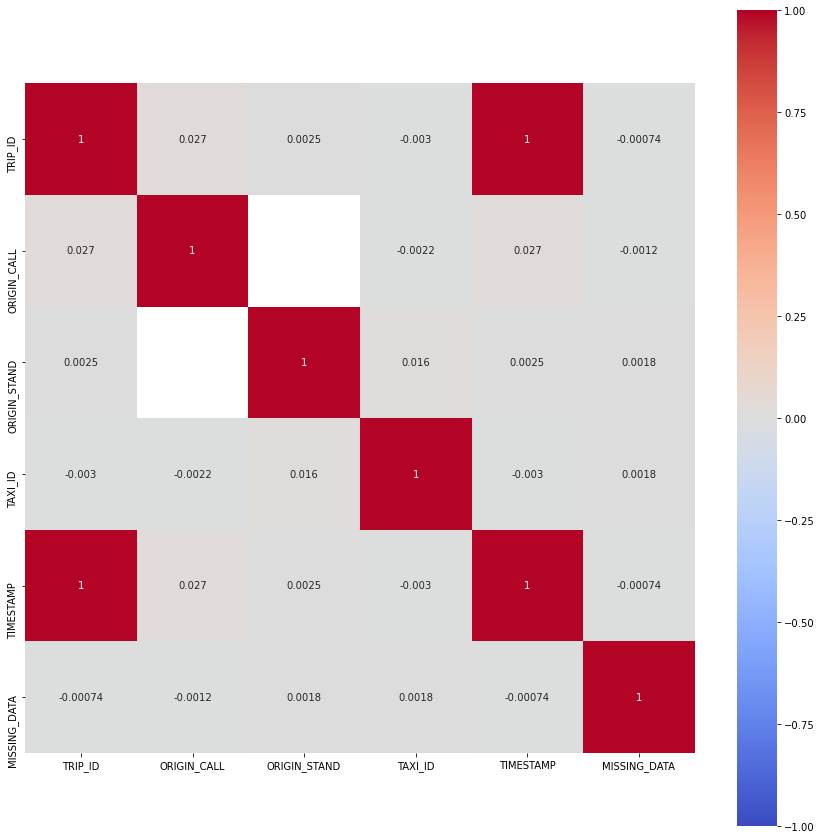

In [11]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True)

<AxesSubplot:>

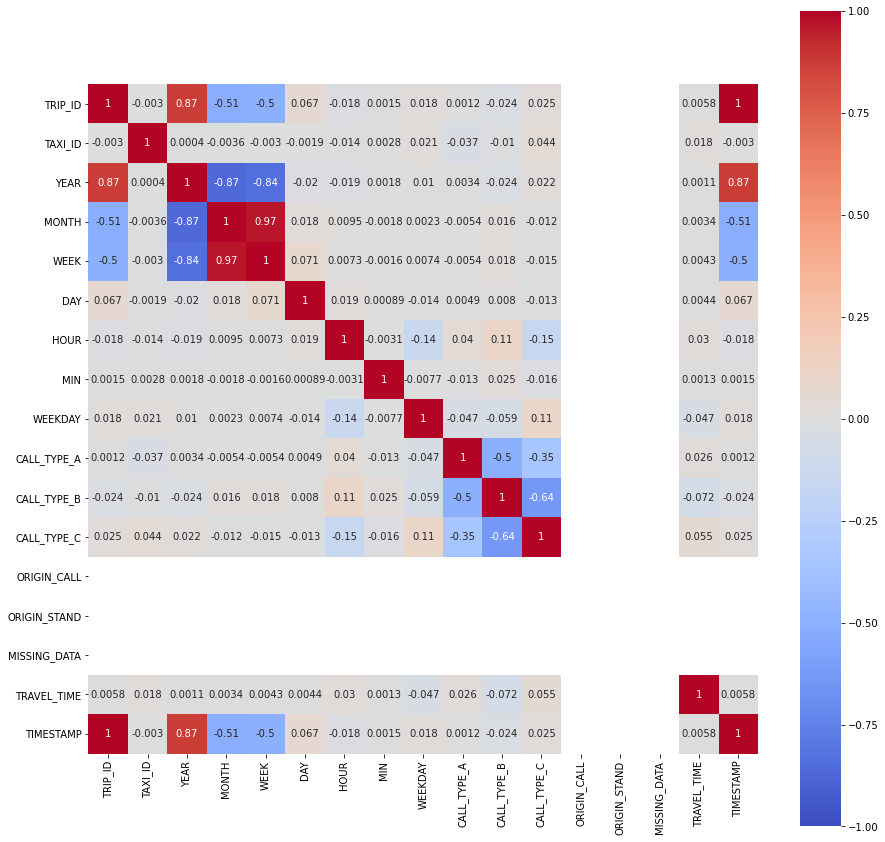

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(dftrain.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',square=True)

In [22]:
set(dftrain.ORIGIN_CALL)

{1}

### 2B - Rationales of normalizing data

<AxesSubplot:xlabel='TRAVEL_TIME'>

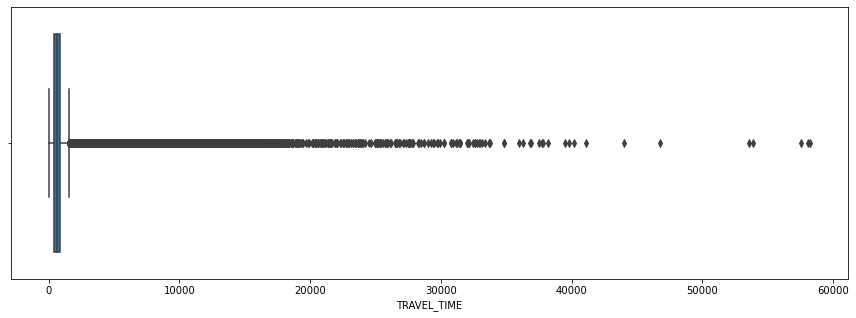

In [17]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(dftrain.TRAVEL_TIME)

## 2B - Other EDA

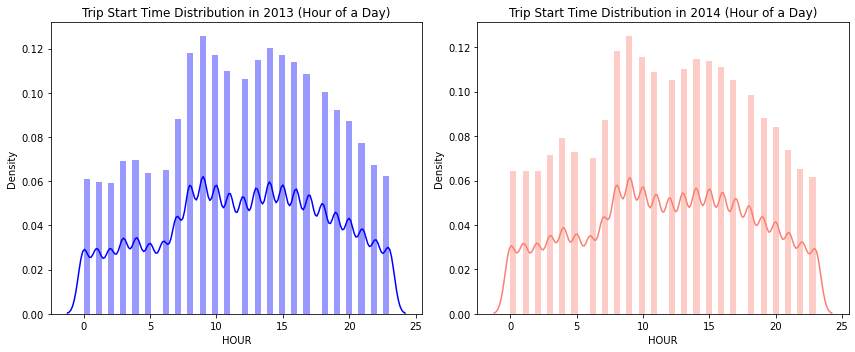

In [25]:
years = [2013,2014]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
axs = axs.flatten()

colors=['blue', 'salmon']
i = 0
for year in years:
    data = dftrain[dftrain.YEAR == year]
    sns.distplot(data.HOUR, ax=axs[i], color=colors[i])
    axs[i].set_title(f'Trip Start Time Distribution in {year} (Hour of a Day)')
    i += 1

plt.tight_layout()
plt.show()

In [27]:
df_noMISSING = df[df.MISSING_DATA == False]

In [34]:
df_noMISSING.groupby('CALL_TYPE').count()['TRIP_ID']

CALL_TYPE
A    364769
B    817878
C    528013
Name: TRIP_ID, dtype: int64

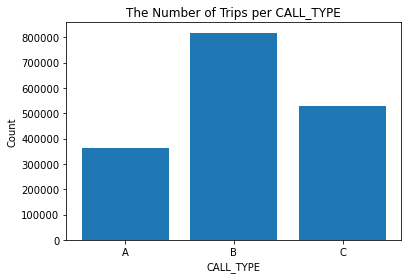

In [36]:
# Data
x = ['A', 'B', 'C']
y = [364769, 817878, 528013]

# Create a bar chart
plt.bar(x, y)

# Add labels and title
plt.xlabel('CALL_TYPE')
plt.ylabel('Count')
plt.title('The Number of Trips per CALL_TYPE')

# Display the chart
plt.show()

In [72]:
groupby_YYMMDD = dftest.groupby(['YEAR', 'MONTH', 'DAY']).count()['TRIP_ID']
vals = list(groupby_YYMMDD)
days = list(groupby_YYMMDD.index)

In [79]:
print(days)
print(vals)

[(2014, 8, 14), (2014, 9, 30), (2014, 10, 6), (2014, 11, 1), (2014, 12, 21)]
[74, 77, 77, 62, 30]


In [80]:
print(dftrain[(dftrain['YEAR'] == 2013) & (dftrain['MONTH'] == 8) & (dftrain['DAY'] == 14)].shape[0])
print(dftrain[(dftrain['YEAR'] == 2013) & (dftrain['MONTH'] == 9) & (dftrain['DAY'] == 30)].shape[0])
print(dftrain[(dftrain['YEAR'] == 2013) & (dftrain['MONTH'] == 10) & (dftrain['DAY'] == 6)].shape[0])
print(dftrain[(dftrain['YEAR'] == 2013) & (dftrain['MONTH'] == 11) & (dftrain['DAY'] == 1)].shape[0])
print(dftrain[(dftrain['YEAR'] == 2013) & (dftrain['MONTH'] == 12) & (dftrain['DAY'] == 21)].shape[0])

4448
4885
4751
6073
6428


In [114]:
html_code = '''
<html>
  <head>
    <script type="text/javascript" src="https://www.gstatic.com/charts/loader.js"></script>
    <script type="text/javascript">
      google.charts.load("current", {packages:["calendar"]});
      google.charts.setOnLoadCallback(drawChart);

   function drawChart() {
       var dataTable = new google.visualization.DataTable();
       dataTable.addColumn({ type: 'date', id: 'Date' });
       dataTable.addColumn({ type: 'number', id: 'Trip Count' });
       dataTable.addRows([
          [ new Date(2013, 7, 14), Math.ceil(Math.log(4448)) ],
          [ new Date(2013, 8, 30), Math.ceil(Math.log(4885)) ],
          [ new Date(2013, 9, 6), Math.ceil(Math.log(4751)) ],
          [ new Date(2013, 10, 1), Math.ceil(Math.log(6073)) ],
          [ new Date(2013, 11, 21), Math.ceil(Math.log(6428)) ],
          [ new Date(2014, 7, 14), Math.ceil(Math.log(74)) ],
          [ new Date(2014, 8, 30), Math.ceil(Math.log(77)) ],
          [ new Date(2014, 9, 6), Math.ceil(Math.log(77)) ],
          [ new Date(2014, 10, 1), Math.ceil(Math.log(62)) ],
          [ new Date(2014, 11, 21), Math.ceil(Math.log(30)) ],
        ]);

       var chart = new google.visualization.Calendar(document.getElementById('calendar_basic'));

       var options = {
         title: "ln(Trip Counts) for Selected Days in Aug-Dec",
         height: 320,
       };

       chart.draw(dataTable, options);
   }
    </script>
  </head>
  <body>
    <div id="calendar_basic" style="width: 1000px; height: 350px;"></div>
  </body>
</html>
'''
display(HTML(html_code))

## 3B / 4B - Models

### Model 0: Simple "Decision Tree"

In [133]:
dfsmall = df[['TAXI_ID', 'CALL_TYPE', 'TRAVEL_TIME']]

In [134]:
dfsmall = dfsmall.dropna()

In [135]:
dfsmall.tail()

,TAXI_ID,CALL_TYPE,TRAVEL_TIME
1710665,20000698,C,465
1710666,20000670,C,435
1710667,20000264,C,0
1710668,20000248,B,915
1710669,20000079,B,390


In [136]:
uniq_taxi_ids = dfsmall.TAXI_ID.unique()

In [137]:
mean_time_by_taxi_id = dfsmall.groupby('TAXI_ID')['TRAVEL_TIME'].mean() 
mean_time_by_call_type = dfsmall.groupby('CALL_TYPE')['TRAVEL_TIME'].mean() # .max()/10 gives really bad preds

In [138]:
%%time
ids = ['TRIP_ID']
preds = ['TRAVEL_TIME']
for i in dftest.iterrows():
    out_id = i[1]['TRIP_ID']
    taxi_id = i[1]['TAXI_ID']
    if taxi_id in uniq_taxi_ids:
        time = round(mean_time_by_taxi_id[taxi_id],0)
    else:
        call_type = i[1]['CALL_TYPE']
        time = round(mean_time_by_call_type[call_type],0)
    ids.append(out_id)
    preds.append(time)

CPU times: user 33.1 ms, sys: 2.02 ms, total: 35.2 ms
Wall time: 33.1 ms


## Some more feature engineering

In [141]:
dftrain = pd.read_csv('dftrain.csv')
dftest = pd.read_csv('dftest.csv')

In [142]:
%%time
Xtrain = []
ytrain = []

gap = 100_000
start = 0
end = start + gap
df_end = dftrain.shape[0]
flag = False

while end < df_end:
    print('Process rows: start =', start, 'end =', end)
    tmp_dftrain = dftrain[start:end]
    
    for row in tmp_dftrain.iterrows():
        Xtrain.append(np.array(row[1])[2:-1])
        ytrain.append([np.array(row[1])[-1]])
    
    start = start + gap
    end = start + gap
    
    if end > df_end - 1:
        if not flag:
            end = df_end - 1
            flag = True

Process rows: start = 0 end = 100000
Process rows: start = 100000 end = 200000
Process rows: start = 200000 end = 300000
Process rows: start = 300000 end = 400000
Process rows: start = 400000 end = 500000
Process rows: start = 500000 end = 600000
Process rows: start = 600000 end = 700000
Process rows: start = 700000 end = 800000
Process rows: start = 800000 end = 900000
Process rows: start = 900000 end = 1000000
Process rows: start = 1000000 end = 1100000
Process rows: start = 1100000 end = 1200000
Process rows: start = 1200000 end = 1300000
Process rows: start = 1300000 end = 1400000
Process rows: start = 1400000 end = 1500000
Process rows: start = 1500000 end = 1600000
Process rows: start = 1600000 end = 1700000
Process rows: start = 1700000 end = 1710659
CPU times: user 59.3 s, sys: 2.15 s, total: 1min 1s
Wall time: 1min 1s


In [143]:
%%time
Xtest = []
for row in dftest.iterrows():
    Xtest.append(np.array(row[1])[2:])

CPU times: user 27.9 ms, sys: 1.14 ms, total: 29.1 ms
Wall time: 27.2 ms


In [150]:
row[1][2:-1]

YEAR            2014
MONTH             12
WEEK              51
DAY               21
HOUR              14
MIN               17
WEEKDAY            6
CALL_TYPE_A        1
CALL_TYPE_B        0
CALL_TYPE_C        0
ORIGIN_CALL        1
ORIGIN_STAND       1
MISSING_DATA       0
Name: 319, dtype: object

### Model 1: Linear regression

In [144]:
%%time
# Model 1
lr = LinearRegression(n_jobs=1)

# Fitting
lr = lr.fit(Xtrain[:500_000], ytrain[:500_000])
lr = lr.fit(Xtrain[500_000:], ytrain[500_000:])

CPU times: user 5.31 s, sys: 9.35 s, total: 14.7 s
Wall time: 3.69 s


In [145]:
# Predict
preds = lr.predict(Xtest)

### Model 2: Random forest

In [152]:
%%time
forest = RandomForestRegressor(n_estimators=100, random_state=1)

# Fitting
forest = forest.fit(Xtrain[:500_000], ytrain[:500_000])
forest = forest.fit(Xtrain[500_000:], ytrain[500_000:])

CPU times: user 5min 44s, sys: 4.64 s, total: 5min 48s
Wall time: 5min 49s


In [ ]:
# Predict
preds = forest.predict(Xtest)

### Model 3: Combined models

- Example:

```
model0 = pd.read_csv('outputs/decision_tree_pred.csv')
model1 = pd.read_csv('outputs/linear_regression_pred.csv')
```

```
ids = ['TRIP_ID']
preds = ['"TRAVEL_TIME"']

j = 0
for i in model0.iterrows():
    out_id = i[1]['TRIP_ID']
    time = round((model0[model0['TRIP_ID'] == out_id]['TRAVEL_TIME']*2
            +model1[model1['TRIP_ID'] == out_id]['TRAVEL_TIME'])/3)[j]
    j += 1
    ids.append(out_id)
    preds.append(time)
```

### Model 4: Weighted average of percentiles

- In notebook: [CSE 151B] Final Model [Thy]-final version

```
preds=[]
for i in list(dftest['TAXI_ID']):
    tmp=dftrain[(dftrain.TAXI_ID==i)]['TRAVEL_TIME']
    p=(np.percentile(tmp,25)+np.percentile(tmp,50)+np.percentile(tmp,75)+np.percentile(tmp,99.5))/9
    preds.append(p)
```

### Models 5, 6: Deep learning models

- Code is intended to be run on a small portion of data to avoid a dead kernel

#### Get train/test for 1st TAXI_ID

In [154]:
trips_id = []
travel_preds = []

for taxi_id in [20000542]:
    newtrain=dftrain[dftrain['TAXI_ID'] == taxi_id]
    
    train_corr=newtrain[['TRAVEL_TIME', 'YEAR', 'MONTH', 'WEEK', 'DAY', 'HOUR', 'MIN', 'WEEKDAY']].corr()
    positive_corr_list=list(train_corr[train_corr > 0]['TRAVEL_TIME'].dropna().keys())
    positive_corr_list.remove('TRAVEL_TIME')

#### Cut outliers

In [156]:
tmpdf = newtrain
Q1 = tmpdf['TRAVEL_TIME'].quantile(0.25)
Q3 = tmpdf['TRAVEL_TIME'].quantile(0.5)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

new_train = newtrain[newtrain.TRAVEL_TIME >= lower_bound]
new_train = newtrain[newtrain.TRAVEL_TIME <= upper_bound]

#### One-hot encoding

In [158]:
years = {
    2013: [1, 0],
    2014: [0, 1]
}

tmp_day = np.zeros(len(new_train.DAY.unique()))
days = {}
for d in list(new_train.DAY):
    tmp = list(tmp_day)
    tmp[d-1] = tmp[d-1] + 1
    days[d] = tmp

In [159]:
tmp_hr = np.zeros(len(new_train.HOUR.unique()))
hrs = {}
for h in list(new_train.HOUR):
    tmp = list(tmp_hr)
    tmp[h-1] = tmp[h-1] + 1
    hrs[h] = tmp

In [160]:
tmp_min = np.zeros(len(new_train.MIN.unique()))
mins = {}
for m in list(new_train.MIN):
    tmp = list(tmp_min)
    tmp[m-1] = tmp[m-1] + 1
    mins[m] = tmp

In [161]:
positive_corr_list

['YEAR', 'DAY', 'HOUR', 'MIN']

In [162]:
tmp_travel_time = np.zeros(len(new_train.TRAVEL_TIME.unique()))
uniq_travels = new_train.TRAVEL_TIME.unique()
times = {}
for i in range(len(tmp_travel_time)):
    tmp = list(tmp_travel_time)
    tmp[i] = 1
    times[uniq_travels[i]] = tmp

In [163]:
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in positive_corr_list:
        if elem == 'YEAR':
            lst = lst + years[row[1]['YEAR']]
        if elem == 'DAY':
            lst = lst + days[row[1]['DAY']]
        if elem == 'HOUR':
            lst = lst + hrs[row[1]['HOUR']]
        if elem == 'MIN':
            lst = lst + mins[row[1]['MIN']]
    Xtrain.append(np.array(lst))
    ytrain.append(np.array(times[row[1]['TRAVEL_TIME']]))

In [ ]:
import tensorflow as tf

Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

X_train = tf.convert_to_tensor(np.array(Xtrain[:int(Xtrain.shape[0]*2/3)]))
y_train = tf.convert_to_tensor(np.array(ytrain[:int(Xtrain.shape[0]*2/3)]))

X_val = tf.convert_to_tensor(np.array(Xtrain[int(Xtrain.shape[0]*2/3):]))
y_val = tf.convert_to_tensor(np.array(ytrain[int(Xtrain.shape[0]*2/3):]))

#### True-value feature engineering

In [166]:
Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in positive_corr_list:
        lst.append(row[1][elem])
    Xtrain.append(np.array(lst))
    ytrain.append(np.array(times[row[1]['TRAVEL_TIME']]))

In [168]:
Xtrain = np.array(Xtrain)
ytrain = np.array(ytrain)

X_train = tf.convert_to_tensor(np.array(Xtrain[:int(Xtrain.shape[0]*4/5)]))
y_train = tf.convert_to_tensor(np.array(ytrain[:int(Xtrain.shape[0]*4/5)]))

X_val = tf.convert_to_tensor(np.array(Xtrain[int(Xtrain.shape[0]*1/5):]))
y_val = tf.convert_to_tensor(np.array(ytrain[int(Xtrain.shape[0]*1/5):]))

### Model 5: MLP

In [176]:
# Define the model
model = Sequential()
model.add(Dense(64, activation='softmax', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(64, activation='softmax'))
model.add(Dense(1, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5
119/119 [==============================] - 2s 11ms/step - loss: 0.9846 - mse: 0.9846 - val_loss: 0.9846 - val_mse: 0.9846
Epoch 2/5
119/119 [==============================] - 1s 9ms/step - loss: 0.9846 - mse: 0.9846 - val_loss: 0.9846 - val_mse: 0.9846
Epoch 3/5
119/119 [==============================] - 1s 9ms/step - loss: 0.9846 - mse: 0.9846 - val_loss: 0.9846 - val_mse: 0.9846
Epoch 4/5
119/119 [==============================] - 1s 9ms/step - loss: 0.9846 - mse: 0.9846 - val_loss: 0.9846 - val_mse: 0.9846
Epoch 5/5
119/119 [==============================] - 1s 9ms/step - loss: 0.9846 - mse: 0.9846 - val_loss: 0.9846 - val_mse: 0.9846


### Model 6: LSTM

In [ ]:
trips_id = []
travel_preds = []

for taxi_id in [20000542]:
    new_train=dftrain[dftrain['TAXI_ID'] == taxi_id]

Xtrain = []
ytrain = []

for row in new_train.iterrows():
    lst = []
    for elem in ['WEEK']:
        lst.append(row[1][elem])

    Xtrain.append(np.array(lst))
    value = row[1]['TRAVEL_TIME']
    ytrain.append(np.array([value]))
    
    X_train = np.array(Xtrain)
    y_train = np.array(ytrain)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    y_train = np.reshape(y_train, (-1,1))

timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = 1

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(timesteps, features)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='relu'))

# Compile the model
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

# Train the model
model.fit(X_train, y_train, epochs=10,verbose=False)#, validation_data=(X_val, y_val))

tmp_test=dftest[dftest['TAXI_ID'] == taxi_id]  
for row in tmp_test.iterrows():
    trip_id = row[1]['TRIP_ID']

    lst = []
    for elem in ['WEEK']:
        lst.append(row[1][elem])

    #Reshape your data either using array.reshape(-1, 1) if your data has a single feature 
    #or array.reshape(1, -1) if it contains a single sample.
    pred = model.predict(np.array(lst).reshape(1,-1))[0][0]
    #print(trip_id,pred)

### Model 7: LDA
- In notebook: [CSE 151B] Final Model [Thy]-final version

### Model 8: LDA + swap indices
- In notebook: [CSE 151B] Final Model [Thy]-final version